# Predicting Game Newsletter Subscription Using K-Nearest Neighbors

## Introduction
The purpose of this data science project is to analyze and predict player behaviours on a Minecraft server based on data collected by a UBC Computer Science research group. This data consisted of two primary files: players.csv and sessions.csv. The players.csv file included detailed information about each player, such as their age, experience level, email, and other personal traits. The sessions.csv file tracked individual play sessions for each player based on their email, including data on session times. 



### Research Question

**What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**

The specific question we addressed in this project is: "Can experience level, age, and total hours played predict newsletter subscription?"

By analyzing both the age and the experience level of a player, we will build a predictive model (K-NN Classification) to assess the likelihood of player subscribing to the newsletter based on such characteristics.


To answer this question, we focus solely on using the players.csv dataset file, as it includes the relevant characteristics (age and experience level) we will be using to hypothesize a player's subscription behaviour. This will involve exploring the dataset to understand the relationships between these variables and subscription status, followed by the development and assessment of the accuracy of our model to form predictions. 



### Dataset Description

The `players` dataset contains 196 observations with the following variables:

- `experience` (chr): Player experience level (Pro, Veteran, Regular, Amateur)
- `subscribe` (lgl): Whether the player subscribed to the newsletter
- `played_hours` (dbl): Total hours played
- `Age` (dbl): Player's age
- `gender` (chr): Player's gender
- `hashedEmail` (chr): Player's email (not used in this analysis)
- `name` (chr): Player's name (not used in this analysis)

This analysis uses techniques covered in the DSCI 100 course including data wrangling, visualization, and K-Nearest Neighbors classification.


## Methods and Results

K-NN classification is a method where the goal is to predict a categorical label. In the case of this project, the K-NN classification model will work well in helping classify whether a player is or will be suscribed to the newsletter based on the player's features.

K-NN classifies new observations by comparing them to similar, labeled examples in the training set. This is effective when we want to base predictions not on assumptions about the data, but on how similar a new observation is to other known observations. Since we are working with a binary classification (TRUE/FALSE) and want to leverage patterns found in past player behavior, K-NN is a suitable choice for building our predictive model.







**We selected the K-Nearest Neighbors (KNN) algorithm because it is non-parametric, easy to understand, and directly influenced by the similarity between features. This cooperates well with our small dataset and helps build an easy understanding of how different features impact prediction outcomes.**

**Because our predictors are categorical variables, we performed one-hot encoding to convert them into a numerical format to be used for the KNN algorithm.**

**Before modeling, we prepared the dataset as follows:**

- Removed unnecessary variables (ie `name`, `hashedEmail`)
- Removed rows with missing values using na.omit()



In [1]:
# load the necessary libraries and packages
library(tidyverse)
library(class)
library(ggplot2)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 10)
library(recipes)
library(themis)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [4]:
# Reading players.csv file
# Reading players.csv file
url_player <- "https://drive.google.com/uc?id=1pD2UbBtMG1NHjlCo4HYVrvy72jilNUv-"
download.file(url_player, destfile = "players.csv")
players <- read_csv("players.csv") 

players_clean <- players |>
    select(-hashedEmail, -name) |>
    mutate(subscribe = as.factor(subscribe)) |>
    na.omit()

# view the first 6 rows of data
head(players_clean)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,gender,Age
<chr>,<fct>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17


Upon inspecting the file, we observed that the number of subscribers exceeds the number of non-subscribers. To verify this, we created a table to compare the counts of each group. As shown below, 73% are subscribers, while 27% are non-subsribers. Given this class imbalance, we will upsample the response variable once we build the model to ensure a more balanced representation.

In [6]:
num_obs <- nrow(players)

players_subscribe <- players |>
  group_by(subscribe) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

players_subscribe

subscribe,count,percentage
<lgl>,<int>,<dbl>
FALSE,52,26.53061
TRUE,144,73.46939


We then summarized numeric features to understand their scale and variance (e.g., max, min, mean).

In [7]:
players_clean |> 
  summarise(
    max_hours = max(played_hours),
    min_hours = min(played_hours),
    mean_hours = mean(played_hours),
    max_age = max(Age),
    min_age = min(Age),
    mean_age = mean(Age)
  )


max_hours,min_hours,mean_hours,max_age,min_age,mean_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
223.1,0,5.904639,50,8,20.52062


### **Findings on Player Type Differences**  

We visualized three relationships:

- Subscription Rate by Experience Level

- Played Hours vs Subscription

- Age Distribution vs Subscription


Based on the visualizations generated, we can analyze the vary in characteristics and how these factors influence **subscription behaviour**.

**Figure 1** below illustrates subscription rate by experience level.

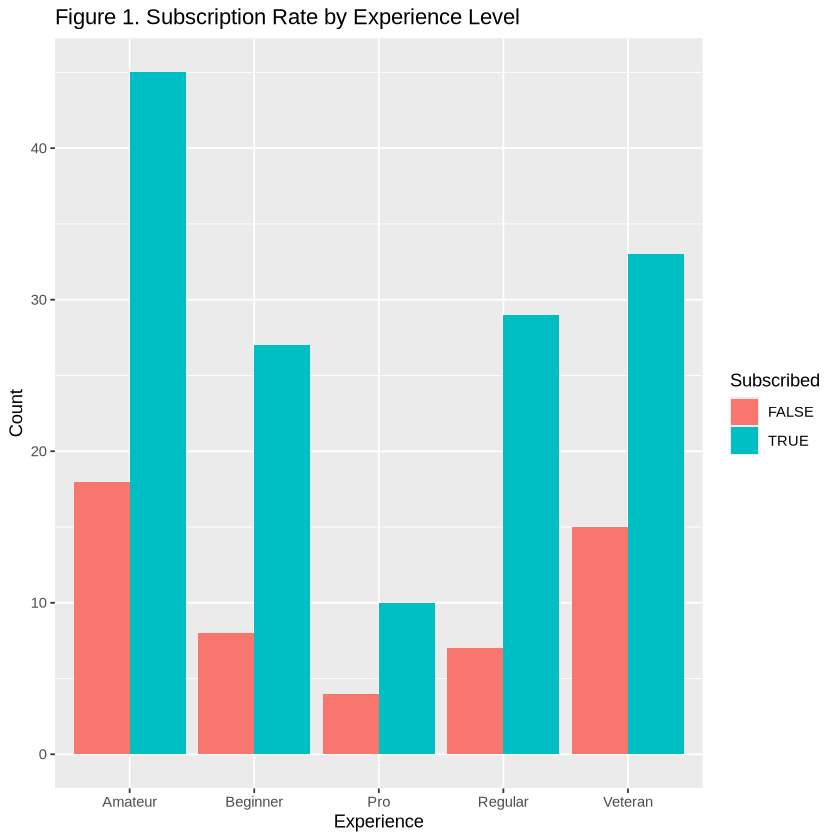

In [5]:
ggplot(players, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(title = "Figure 1. Subscription Rate by Experience Level", x = "Experience", y = "Count", fill = "Subscribed")


**Figure 2** illsutrates the relationship between played hours and subscription below.

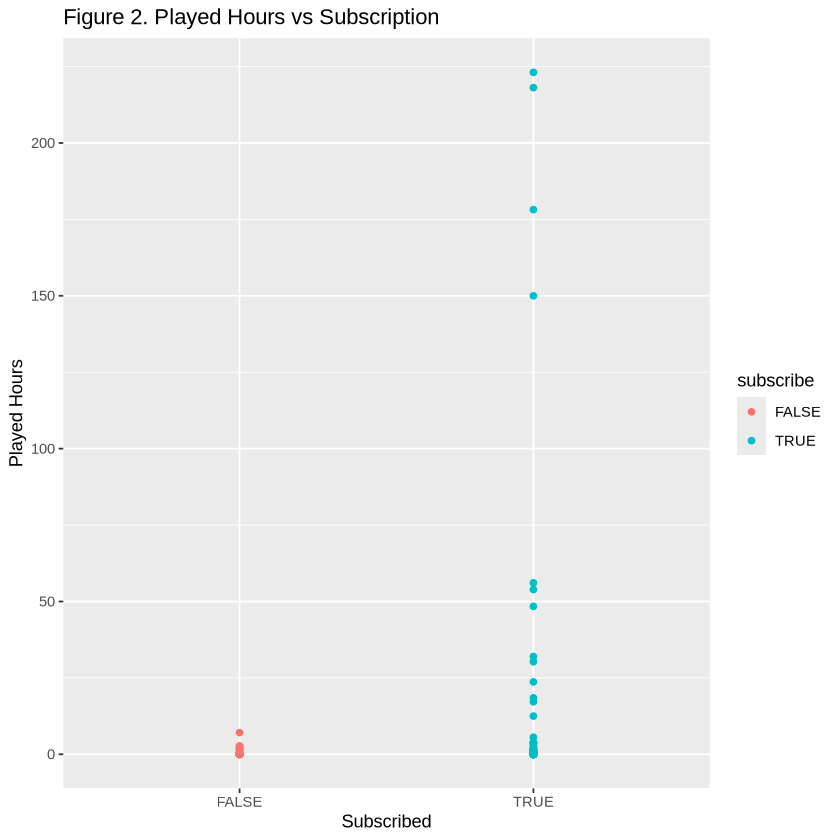

In [11]:
ggplot(players, aes(x = subscribe, y = played_hours, color = subscribe)) +
  geom_point() +
  labs(
    title = "Figure 2. Played Hours vs Subscription",
    x = "Subscribed",
    y = "Played Hours"
  )


**Figure 3** below illustrates the distribution of a player's age with subscription.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


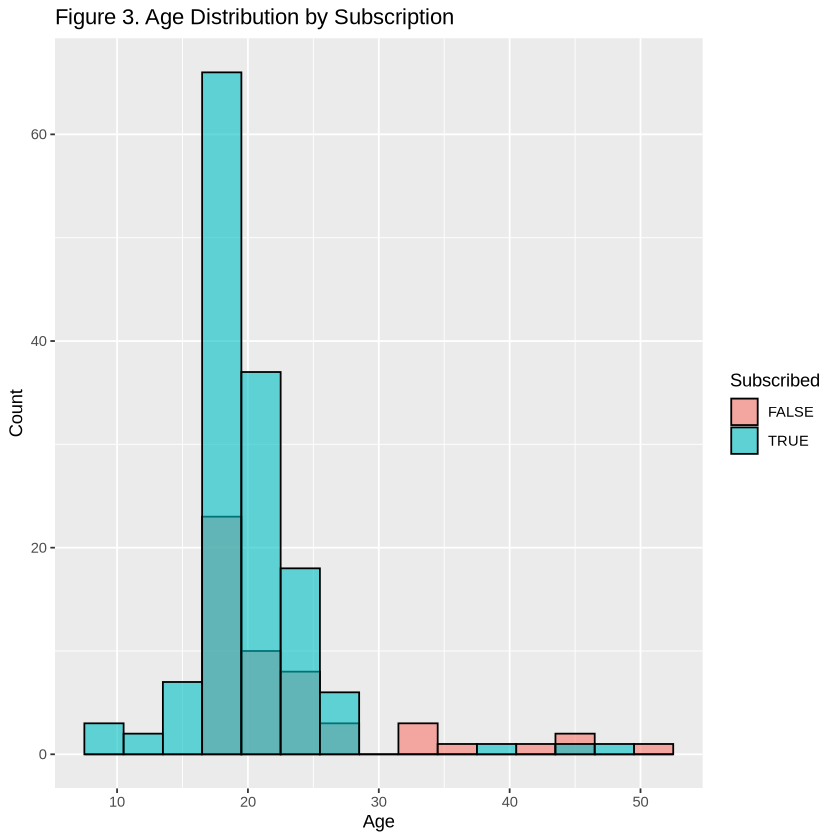

In [10]:
ggplot(players, aes(x = Age, fill = subscribe)) +
  geom_histogram(bins = 15, alpha = 0.6, position = "identity", color = "black") +
  labs(title = "Figure 3. Age Distribution by Subscription", x = "Age", y = "Count", fill = "Subscribed")


#### Experience Level vs Subscription Rate (Figure 1)
- Pro and Veteran players have the highest subscription rates, while Regular and Amateur players have lower subscription rates.

#### Played Hours vs Subscription (Figure 2)
- Subscribed players tend to have higher median played hours.


#### Age vs Subscription (Figure 3)
- Younger players are more likely to subscribe, while older players (above 30) show a lower subscription rate.

### **Training the Model**  

We first split the dataset into training and test sets using an 70/30 ratio using `initial_split()` function. 

In [14]:
set.seed(123)

players_split <- initial_split(players_clean, prop = 0.70, strata = subscribe)

players_train <- training(players_split)

players_test <- testing(players_split)

Then we create the recipe, ensuring to use the `scale()` function to normalize numerical predictors to ensure they are on comparable scales, which is essential for K-NN performance. 

As mentioned in the introduction, we also perform one-hot encoding through the `step_dummmy()` function to convert `experience` into numeric binary terms. Due to class imbalance (fewer non-subscribers than subscribers), we upsample the subscribe variable using `step_upsample()`. This will create a balanced dataset by replicating non-subscriber cases until both have equal representation. 

Finally, we define a K-NN model with `nearest_neighbor()` adding the defined recipe and with an initial guess of 3 neighbours which will later be tuned.

In [15]:
set.seed(3030) # DO NOT REMOVE
players_recipe <- recipe(subscribe ~ Age + experience + played_hours, data = players_clean) |>
    step_dummy(experience, one_hot = TRUE) |> # To turn into numeric binary model terms
    step_upsample(subscribe, over_ratio = 1) |>  # To upsample subscribers : over_ratio = 1 means 1:1 ratio
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

players_recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Dummy variables from: experience

• Up-sampling based on: subscribe

• Scaling for: all_predictors()

• Centering for: all_predictors()



To find the best k value, we can evaluate the accuracy of each k value by performing a 10-fold cross-validation split of our training data using `vfold_cv()` setting strata as our categorical label variable, `subscribe`. The new workflow we create is fit across all cross-validation folds through `fit_resamples()`, and we collect the aggregated performance metrics, quantifying how well our model performs across multiple validation runs.

Making a new K-NN specification, we make the number of neighbours as tunable through `tune()`, then create a grid of potential k values ranging from 1 to 40. Using `tune_grid()`, we evaluate each k value with our 10-fold cross-validation. After collecting all results, we filter the accuracy metrics and visualize the relationship between k and model accuracy, and plot the results in Figure 5, showing how model performance varies with k. This helps identify the value where accuracy peaks before overfitting or underfitting potentially occurs.

We then select the value of 26 as the best k value.

[1] 26

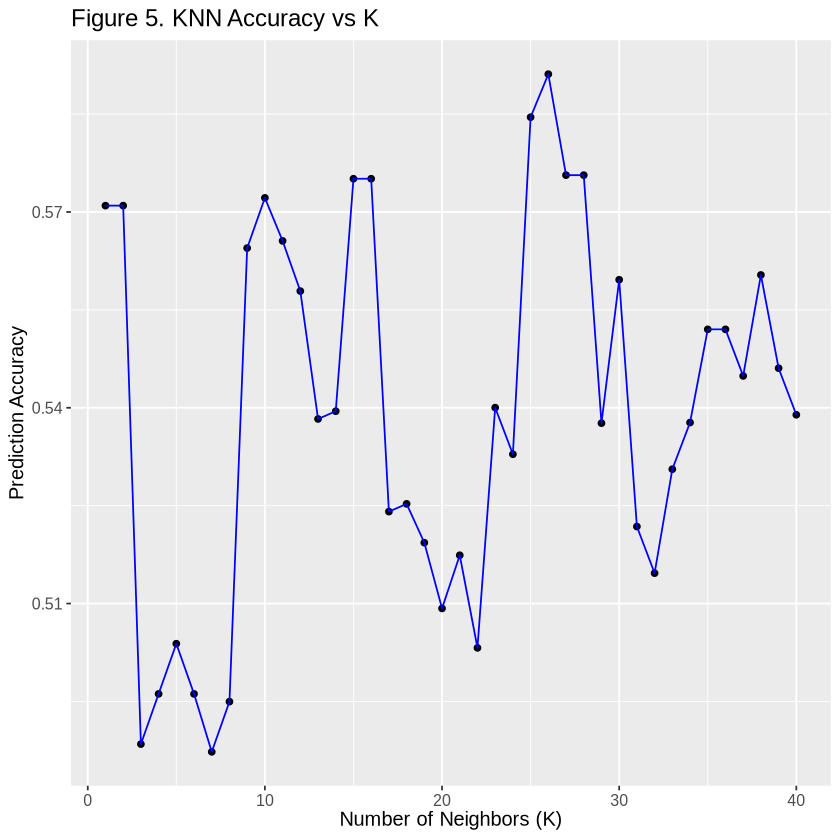

In [16]:
set.seed(1010) # DO NOT REMOVE


players_vfold <- vfold_cv(players_train, v = 10, strata = subscribe)

players_vfold_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = players_vfold)


players_metrics <- collect_metrics(players_vfold_fit)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line(color = "blue") +
  labs(
    title = "Figure 5. KNN Accuracy vs K",
    x = "Number of Neighbors (K)",
    y = "Prediction Accuracy"
  ) +
  theme(text = element_text(size = 12))

accuracy_vs_k

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

After identifying the optimal k value from above (`best_k`), we create a new K-NN specification model using this value. The model was combined with the previously preprocessed recipe in a new workflow, which was then fit to our entire training set (`players_train`) to create the final predictive model. 

In [17]:
set.seed(4040) # DO NOT REMOVE

# Creating model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)


Using our model, we generate predictions on our test set (`players_test`) to evaluate its performance on unseen data.

In [18]:
set.seed(2020) # DO NOT REMOVE

players_test_predictions <- predict(knn_fit, players_test) |>
  bind_cols(players_test)

players_test_predictions 


.pred_class,experience,subscribe,played_hours,gender,Age
<fct>,<chr>,<fct>,<dbl>,<chr>,<dbl>
TRUE,Pro,TRUE,30.3,Male,9
TRUE,Veteran,TRUE,3.8,Male,17
TRUE,Veteran,FALSE,0.0,Male,17
TRUE,Amateur,TRUE,0.7,Female,21
TRUE,Amateur,FALSE,0.0,Male,21
⋮,⋮,⋮,⋮,⋮,⋮
TRUE,Veteran,TRUE,0.0,Male,17
TRUE,Amateur,TRUE,0.3,Male,17
FALSE,Veteran,FALSE,2.7,Non-binary,21


Finally, we calculated the accuracy of our model by comparing it with the estimate of the response variable to the actual observation. We first compute the overall classification accuracy, which represents the proportion of correct predictions across all observations. We then examine precision, which measures how many of the predicted positive cases were actually positive. Then, we assess recall , which calculates what proportion of actual positive cases our model has successfully identified.

In [21]:
set.seed(2020) # DO NOT REMOVE

players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level="first")

players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level="first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7118644


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.4545455


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.3125


Given our model's suboptimal metrics (71% accuracy, 45% precision, and 31% recall), we can observe the confusion matrix to understand the specific patterns in prediction errors.

In [23]:
confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     5    6
     TRUE     11   37

## Discussion

### **What we found**
**Figure 1: Subscription Rate by Experience Level**  
The plot clearly shows that players with higher experience levels (Veteran and Pro) have higher subscription rates than Regular or Amateur players. This matches what we expected and supports the assumption that more experienced players are more engaged with the game and thus more likely to subscribe. What's more, it may also reflect that experienced players have been in the game longer and had more possibility to see the newsletter option.

 **Figure 2: Played Hours vs Subscription**  
The plot indicates that subscribed players tend to have higher median and maximum playtime. This seems intuitive and matches what we expected—more invested players may want to stay updated. However, it’s also possible that subscription leads to more engagement over time (reverse causality).

**Figure 3: Age Distribution by Subscription**  
Younger players appear more likely to subscribe. This may reflect digital habits: younger users tend to be more open to email subscriptions, and more accustomed to in-game notifications and marketing. Oppoesitely, it may be that older users are less willing to accept.                                                              

**Predictive Model**  
With all things considered, the model is most likely to predict a young player with a high experience level and a high playtime as someone who will be subscribed to the newsletter, whereas predict an older player with a low experience level and a low playtime as someone who wouldn't subscribe. Overall, the model can predicts a player's subscription given their age, experience level, and hours played with about a 71% accuracy.

### **Impact**  
These findings can help game developers better understand user behavior. For example, promotional efforts could be tailored to high-playtime players to increase conversions. Knowing that experience and age influence subscription likelihood, marketing emails could highlight tips, achievements, or community events to attract younger or more engaged players. Furthermore, the game team could also consider promoting newsletter subscriptions through platforms like Instagram and TikTok, which are more popular among younger audiences.  
\
What’s more, building a model can help us make predictions, because in reality, user do no only subscribe based on their own preference, but also act in response to the expectations from others. As a result, the final outcome may lead situations where users with the financial ability to subscribe do not do so (David.et al.,2008).  

Additionally, the model can be used to further engage with players that the model predicted to be a potential subscriber. In other words, for players that the model predicts to be a subcriber, further efforts can be given to these players to convince them to subscribe to the newsletter.

### **Limitations of the model**
After evaluating the KNN classification results (accuracy: 0.7119, precision: 0.4545, recall: 0.3125), we identified several reasons that likely affected the model’s performance. These issues can be grouped into these four main parts:

**1.Data quality and consistency issues**  
The dataset seems self-reported by players, thus, there are some inconsistencies. For example, some players are labeled as ”Veteran”, but their play hours is 0. Such contradictions indicate data entry errors. A possible solution is to set data filtering rules: ”Veteran” players must have at least 100 hours of game time.

**2.The model is sensitve to outliers.**  
Extreme values in variables such as played hours or age can interfere with KNN algorithms which affect classification results.

**3.The insufficient sample size**  
With only 196 players in the dataset, the sample may not be sufficiently representative of the overall player population. In particular, certain groups of people (e.g., older players, non-male genders, or very casual users) may be underrepresented, potentially biasing the model’s conclusions. Expanding the dataset with more diverse and balanced samples would improve generalizability of the findings.

**4.The current prediction ability is relatively weak**  
Variables such as age, played hours, and experience level are not good predictors. These variables may have some correlation with subscription status, but there is no strong relationship. For instance, older players may be more likely to subscribe, but this does not mean that age directly causes subscription behavior (reverse causality). Therefore, these variables may introduce noise in the model’s performance.

**5.One of  the more predictive alternative features**  
Platform Bias: The dataset does not capture which channels players encountered or accessed the subscription option. Players who engage primarily via mobile or social platforms might behave differently. Future data collection could include interaction channels to analyze cross-platform behavior differences.

According to the Ampere analysis’s data from Q3 of 2023, the content update strategies of various platforms vary: Netflix (mobile), Xbox and PC have added a large number of games, while some console based service platforms play a trend of decreasing players. This suggests that players on mobile platforms may be experiencing more dynamic content news (Ampere Analysis,et,al 2023).


### **Future Questions**
In this analysis, we only analysize how a players age, experience level, and played hours can determine their subscription. Thus, for future analysis, we can look into how other player features may impact the likelihood that a player will subscribe to the newsletter or not. For example, we can collect data on whether the player prefers group or solo play, which country they are located in, whether they prefer to play competitively or recreationally, and much more. 

Additionally, we only used the players dataset in our analysis. In the future, we could incorporate the time of day the player tends to prefer to game, and build a model incorporating that player characteristic.

## References
Barbieri, F. M., & Malueg, D. A. (2008). Private provision of a discrete public good: Continuous‐strategy equilibria in the private‐information subscription game. Journal of Public Economic Theory, 10(4), 703–727. https://doi.org/10.1111/j.1467-9779.2008.00378.x

Hu, M. (2022). Optimizing free-to-play multiplayer games with premium subscription (Master’s thesis, University of Michigan). University of Michigan Deep Blue. https://hdl.handle.net/2027.42/171291
 
Statista. (2024, March). Number of titles added and removed by video game subscription services during Q3 2023[Graph]. Statista. https://www.statista.com/statistics/1429607/video-game-subscription-services-adding-or-removing-titles-q3-2023/